In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary

In [2]:
batch_size = 32
total_epoch = 30
learning_rate = 0.1
use_cuda = torch.cuda.is_available()
criterion = nn.CrossEntropyLoss()
print(use_cuda)

True


In [3]:
# dataset
train_dataset = dsets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = dsets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Training Function
def train(model,train_loader):
    model.train()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    losses = []
    for i, (image, label) in enumerate(train_loader):
        
        if use_cuda:
            image = image.cuda()
            label = label.cuda()
        
        pred_label = model(image)
        loss = criterion(pred_label, label)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_loss = sum(losses)/len(losses)
    return avg_loss

In [5]:
# Evaluation Fuction
def eval(model, test_loader):
    model.eval()
    device = next(model.parameters()).device.index
    
    total_cnt = 0
    correct_cnt = 0
    
    for i, (image, label) in enumerate(test_loader):
        if use_cuda:
            image = image.cuda()
            label = label.cuda()

        out = model(image)
        _, pred_label = torch.max(out.data, 1)
        total_cnt += image.data.size()[0]
        correct_cnt += (pred_label == label.data).sum().item()
        
    return correct_cnt / total_cnt

In [6]:
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), padding=(1,1))
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=(1,1))
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=(1,1))
        self.act3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=(3,3), padding=(1,1))
        self.act3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=(3,3), padding=(1,1))
        self.act3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=(3,3), padding=(1,1))
        self.act4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1))
        self.act4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1))
        self.act4_3 = nn.ReLU()
        self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # Output layer
        self.fc1 = nn.Linear(512 * 2 * 2, 512)
        self.act5 = nn.ReLU()
        self.out = nn.Linear(512, 10)
        
    def forward(self, x):
        x1 = x
        x2 = self.act1(self.conv1(x1))
        x3 = self.pool1(x2)
        
        x4 = self.act2(self.conv2(x3))
        x5 = self.pool2(x4)
        
        x6 = self.act3_1(self.conv3_1(x5))
        x7 = self.act3_2(self.conv3_2(x6))
        x8 = self.act3_3(self.conv3_2(x7) + x6)
        x9 = self.pool3(x8)
        
        x10 = self.act4_1(self.conv4_1(x9))
        x11 = self.act4_2(self.conv4_2(x10))
        x12 = self.act4_3(self.conv4_2(x11) + x10)
        x13 = self.pool4(x12)
        
        x14 = x13.view(-1, 512 * 2 * 2)
        
        x15 = self.act5(self.fc1(x14))
        
        out = self.out(x15)        
        
        return F.log_softmax(out, dim=1)

In [7]:
# Training & Evaludation
resnet_model = SimpleResNet().cuda()
train_loss_lst = []
test_accuracy_lst = []
for epoch in range(total_epoch):
    train_loss = train(resnet_model, train_loader)
    train_loss_lst.append(train_loss)
    test_accuracy = eval(resnet_model, test_loader)
    test_accuracy_lst.append(test_accuracy)
    
    print("Epoch: [{}/{} ({:.2f}%)]\ttrain_loss: {}\ttest_accuracy: {}".
          format(epoch + 1, total_epoch, 
                 100 * ((epoch + 1) / total_epoch),
                 train_loss, test_accuracy))

summary(resnet_model, input_size = (3,32,32))

Epoch: [1/30 (3.33%)]	train_loss: 1.9950219410318484	test_accuracy: 0.3762
Epoch: [2/30 (6.67%)]	train_loss: 1.4495261545297204	test_accuracy: 0.5277
Epoch: [3/30 (10.00%)]	train_loss: 1.126700343055292	test_accuracy: 0.6296
Epoch: [4/30 (13.33%)]	train_loss: 0.8854724429237941	test_accuracy: 0.7006
Epoch: [5/30 (16.67%)]	train_loss: 0.7076395013282029	test_accuracy: 0.7135
Epoch: [6/30 (20.00%)]	train_loss: 0.5672788409300515	test_accuracy: 0.6827
Epoch: [7/30 (23.33%)]	train_loss: 0.43724743638638114	test_accuracy: 0.7541
Epoch: [8/30 (26.67%)]	train_loss: 0.33412198768600926	test_accuracy: 0.7385
Epoch: [9/30 (30.00%)]	train_loss: 0.2434993543800965	test_accuracy: 0.7069
Epoch: [10/30 (33.33%)]	train_loss: 0.1759466340277351	test_accuracy: 0.7139
Epoch: [11/30 (36.67%)]	train_loss: 0.13572298738225383	test_accuracy: 0.7799
Epoch: [12/30 (40.00%)]	train_loss: 0.10388829417467732	test_accuracy: 0.7605
Epoch: [13/30 (43.33%)]	train_loss: 0.09794721655280675	test_accuracy: 0.7621
Epoch:

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

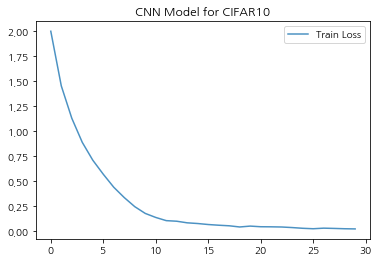

In [9]:
plt.clf()
plt.title("CNN Model for CIFAR10")
plt.plot(train_loss_lst, '-', label='Train Loss', alpha=0.8)
plt.legend(loc='best')
plt.show()

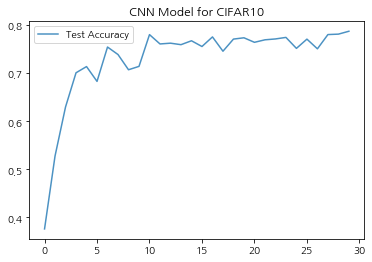

In [10]:
plt.clf()
plt.title("CNN Model for CIFAR10")
plt.plot(test_accuracy_lst, '-', label='Test Accuracy', alpha=0.8)
plt.legend(loc='best')
plt.show()